<a href="https://colab.research.google.com/github/supriyag123/PHD_Pub/blob/main/PAPER_GDRNet_METROPM_Step1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<Axes: >

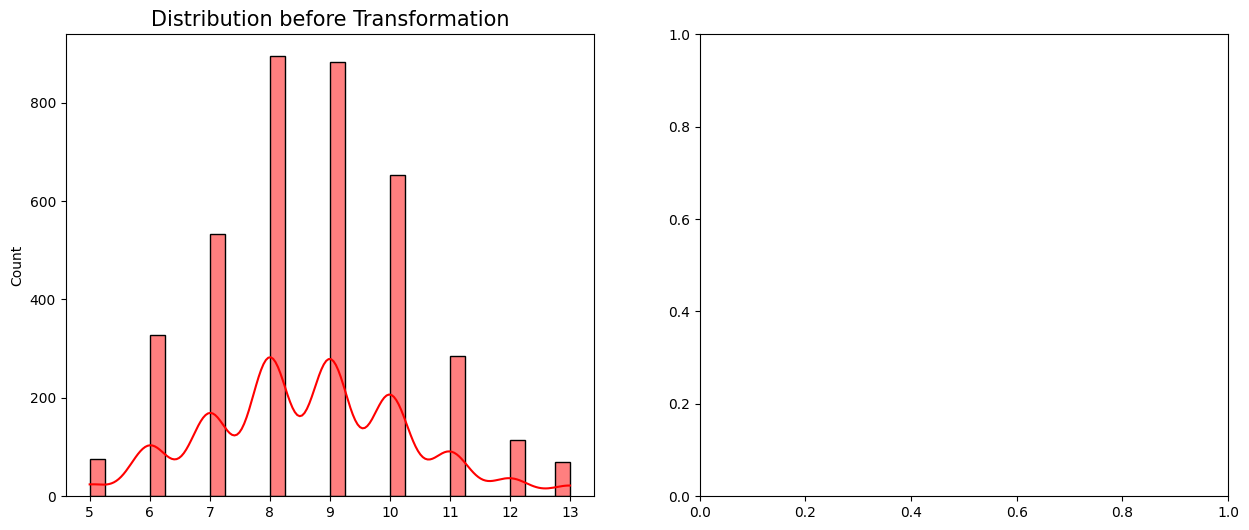

In [24]:
!pip install statsmodels --upgrade
!pip install -U lingam
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import math
import plotly.graph_objects as go
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed, Input
from keras.models import Model
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
import ast
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import TimeSeriesSplit
from numpy import arange
import warnings
warnings.filterwarnings('ignore')
#from keras.utils import plot_model
#import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests
from importlib.metadata import version

#MetroPT dataset: https://archive.ics.uci.edu/dataset/791/metropt+3+dataset


df=pd.read_csv(r'/content/drive/MyDrive/PHD/metropt+3+dataset (1).zip (Unzipped Files)/MetroPT3(AirCompressor).csv', parse_dates={'datetime':[1]}, index_col=['datetime'])
df.head()

#df = df[['Global_active_power','Global_reactive_power','Global_intensity']]
#Imputing NULL
df = df.replace('?', np.nan)
df.isnull().sum()



def fill_missing(values):
    one_day = 60*24*6
    for row in range(df.shape[0]):
        for col in range(df.shape[1]):
            if np.isnan(values[row][col]):
                values[row,col] = values[row-one_day,col]
df = df.astype('float32')
fill_missing(df.values)
df.isnull().sum()


# --------------------------- to perform granger causality on the entire time series history------------------------------to reduce computation--------------####
daily_df = df.resample('H').mean()
daily_df.head()

daily_df = daily_df.dropna(how='any')

ts_len = daily_df.shape[0]

#Now convert index to column
daily_df['datetime']=daily_df.index

#VISUALISE THE TIMESERIES
fig = go.Figure()
fig.add_trace(go.Scatter(x=daily_df['datetime'], y=daily_df['Caudal_impulses'], name='CO(GT)'))

fig.update_layout(showlegend=True, title='Air Quality')
fig.show()

#remove index column unless required.

daily_df.drop(daily_df.columns[0], axis=1, inplace=True)
daily_df.drop(daily_df.columns[15], axis=1, inplace=True)
#daily_df.drop(daily_df.columns[2], axis=1, inplace=True) #dropped Voltage
#Scaling the values
whole_series = daily_df
scalers={}
for i in daily_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(whole_series[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    whole_series[i]=s_s



#Stationarity check for each time series ---- This module can be run manually for now

def augmented_dickey_fuller_statistics(time_series):
  result = adfuller(time_series.values)
  ADF_Statistic = result[0]
  p_value = result[1]
  Critical_values_1 = result[4]["1%"]
  Critical_values_5 = result[4]["5%"]
  Critical_values_10 = result[4]["10%"]

  # We take that p-value should be less than 0.05 and ADF_statistic should be less than critical value at 5% confidence Critical_value_5
  if p_value <0.05 and ADF_Statistic < Critical_values_5:
    return "stationary"
  else:
    return "non-stationary"

for i in range(0,whole_series.shape[1]):
  print('Augmented Dickey-Fuller Test Result:', whole_series.iloc[:,i].name)
  x= augmented_dickey_fuller_statistics(whole_series.iloc[:,i])
  print(x)
  #if any of the x is "non-stationary": df_difference = whole_series.diff() -- and then deal with df_difference

#Granger Causality

max_lag_GC = 50

#https://phdinds-aim.github.io/time_series_handbook/04_GrangerCausality/04_GrangerCausality.html

def granger_causation_matrix(data, variables, p, test = 'ssr_chi2test', verbose=False):
    """Check Granger Causality of all possible combinations of the time series.
    The rows are the response variables, columns are predictors. The values in the table
    are the P-Values. P-Values lesser than the significance level (0.05), implies
    the Null Hypothesis that the coefficients of the corresponding past values is
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], p, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(p)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

granger_causation_matrix(whole_series, whole_series.columns, max_lag_GC)

###############Recall: If a given p-value is < significance level (0.05), then, the corresponding X series (column) causes the Y (row).

#### GRANGER CAUSALITY PROVES that following features are very weakly related with most (almost no ausal effect) hence will be removed. Oil_level was dropped. Two more features were dropped for same reason.

whole_series.drop(whole_series.columns[12], axis=1, inplace=True)
whole_series.drop(whole_series.columns[12], axis=1, inplace=True)
whole_series.drop(whole_series.columns[12], axis=1, inplace=True)

def extract_windows_vectorized(array, large_seq_size):
    start = 0
    last_index = len(array)-1
    max_time =  last_index - large_seq_size +1  ##last index upto which sliding windoe begining can go

    sub_windows = (
        start +
        # expand_dims are used to convert a 1D array to 2D array.
        np.expand_dims(np.arange(large_seq_size), 0) +
        np.expand_dims(np.arange(max_time + 1), 0).T
    ).astype(int)

    return array[sub_windows]


#DEFINE K - User parameter - length of the LONG time series sequence.
K = 48 #taking 1 day of hourly data

large_seq_size = K
n_features = whole_series.shape[1]

Long = extract_windows_vectorized(whole_series.values,large_seq_size)

Long_train = Long


#First, define a function that can generate small subsequences for all the large K sequences

def generate_small_seq(series, n_past, n_future):
  #
  # n_past ==> no of past observations -- OR -- sliding window
  #
  # n_future ==> no of future observations -- prediction variable y
  #
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    # slicing the past and future parts of the window
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)


n_future=1
predictions = list()

rmse_list = list()
min_window_list = list()
best_window_for_long_seq = list()
AIC = list()
n_fold = 6 # 5 fold plus 1 for test)
# evaluate a logistic regression model using k-fold cross-validation
n_future=1
predictions = list()

rmse_list = list()
min_window_list = list()
best_window_for_long_seq = list()
AIC = list()
n_fold = 6 # 5 fold plus 1 for test)
# evaluate a logistic regression model using k-fold cross-validation
from numpy import mean
from numpy import std
from sklearn.feature_selection import VarianceThreshold



best_window_for_long_seq.clear()




#------------------------NEW JUNE 2024 --------------------------------SKIP INDIVIDUAL IOSW--- GO TO COSW DIRECT----------------------------------------------------------------------------------------------------
for i in range(Long_train.shape[0]) :
#for i in range(10) :
  cur_seq = Long_train[i,:,:]
  AIC.clear()
  try:
    selector = VarianceThreshold(0.00002)
    cur_seq = selector.fit_transform(cur_seq)
    model = VAR(cur_seq)
    for m in range(K) :
    #print(Long_train)
      try:
        results = model.fit(m)
        print('Order =', m)
        print('AIC: ', results.aic)
        print('BIC: ', results.bic)
        AIC.append(results.aic)
      except:
        AIC.append(99999)
        print('VAR could not solve row number')
        print(i, m)

    minAIC_index = AIC.index(min(AIC))+1
    print(AIC)
    print('Minimum lag = ', minAIC_index)
    best_window_for_long_seq.append(minAIC_index)

  except:
    print('NOT ENOUGH FEATURES')
    print(i)
    minAIC_index = 99999
    best_window_for_long_seq.append(minAIC_index)







#OUT OF ALL LOOPS NOW
#best_window_for_long_seq now contains the best multivariate window size for each of the long sequence i
print(best_window_for_long_seq)
Window = np.array(best_window_for_long_seq)


np.save(r'/content/drive/MyDrive/PHD/2024/TEMP_OUTPUT_METROPM/multivariate_long_sequences-TRAIN-Daily-DIRECT-VAR.npy',Long_train)
np.save(r'/content/drive/MyDrive/PHD/2024/TEMP_OUTPUT_METROPM/multivariate_long_sequences_WINDOW-Daily-DIRECT-VAR.npy',Window)
#np.save(r'/content/drive/MyDrive/PHD/2021/multivariate_long_sequences-TEST.npy',Long_test)
print('saving completed')

tdata=np.load(r'/content/drive/MyDrive/PHD/2024/TEMP_OUTPUT_METROPM/multivariate_long_sequences-TRAIN-Daily-DIRECT-VAR.npy')
wdata = np.load(r'/content/drive/MyDrive/PHD/2024/TEMP_OUTPUT_METROPM/multivariate_long_sequences_WINDOW-Daily-DIRECT-VAR.npy')

import seaborn as sns
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.title("Distribution before Transformation", fontsize=15)
sns.histplot(wdata, kde=True, color="red")
plt.subplot(1,2,2)



p = np.argwhere((4<wdata) & (14>wdata)).flatten()
wdata_new= np.take(wdata, p, 0)
tdata_new= np.take(tdata,p,0)
tdata_new.shape
wdata_new.shape

np.save(r'/content/drive/MyDrive/PHD/2024/TEMP_OUTPUT_METROPM/multivariate_long_sequences-TRAIN-Daily-DIRECT-VAR.npy',tdata_new)
np.save(r'/content/drive/MyDrive/PHD/2024/TEMP_OUTPUT_METROPM/multivariate_long_sequences_WINDOW-Daily-DIRECT-VAR.npy',wdata_new)

import seaborn as sns
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.title("Distribution before Transformation", fontsize=15)
sns.histplot(wdata_new, kde=True, color="red")
plt.subplot(1,2,2)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# New Section